# Image Classification of Elephants and Zebras using Neural Networks

### Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from skimage import io,color
from skimage.transform import resize
from skimage.util import crop

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.utils.layer_utils import count_params
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.optimizers import SGD
from tensorflow.random import set_seed


from sklearn.metrics import confusion_matrix

## Data Analysis
The data will be loaded into three sets upon which our analysis will take place, namely the training, validation and test sets. Each of the models will be fit on the training data and their respective accuracies will calculated by how close the model's predictions come to the validation set. The test set is reserved for comparing different models with each other to ultimately choose the best model to process with.

A sample plot of the images will be created so that we may get a sense of the input data for this binary image classification problem.

### Display a sample of the images

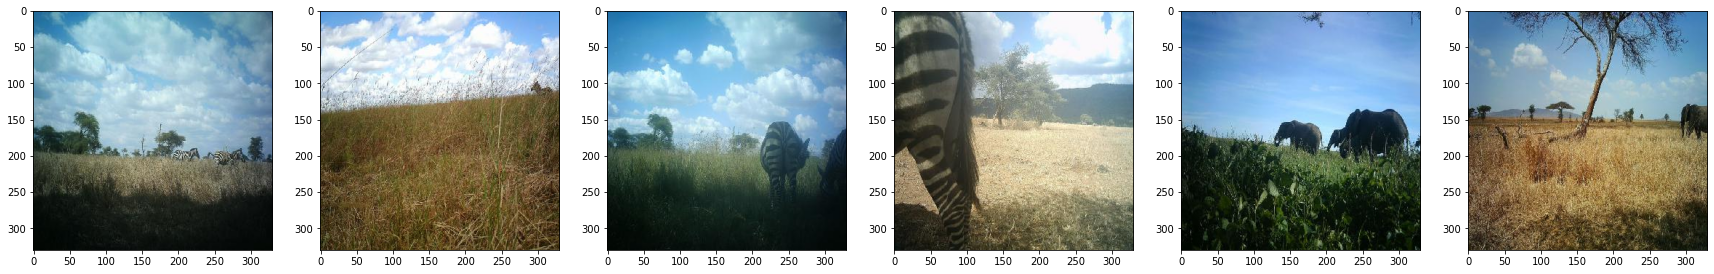

In [2]:
num_plots = 6
fig, ax = plt.subplots(1,num_plots, figsize = (30,50))
directory = r'data/Valid'
np.random.seed(2022)
elephant_or_zebra = ['elephant_valid','zebra_valid']
#Print 6 random images from the data
for i in range(num_plots):
    rand_animal =np.random.randint(2)
    folder = os.path.join(directory,elephant_or_zebra[rand_animal])
    rand_image = np.random.randint(1000)
    ax[i].imshow(io.imread(os.path.join(folder,os.listdir(folder)[rand_image])))
    
plt.show()

### Creation of Training, Validation and Testing Sets

In [3]:
category_train_dir_labels = ['Elephant_train', 'Zebra_train']
category_valid_dir_labels = ['Elephant_valid', 'Zebra_valid']
category_test_dir_labels = ['Elephant_test', 'Zebra_test']

train_directory =r'data/train/'
valid_directory =r'data/valid/'
test_directory =r'data/test/'

labels = ['elephant','zebra']

# Training Set

train_data = []

indexes_of_augmented_images = []#Array to store the indexes all the augmented versions of images for future use
for category_label in category_train_dir_labels:
    folder = os.path.join(train_directory,category_label)
    label=category_train_dir_labels.index(category_label)
    #iterate through the training data directory to append images to train data
    for i, img in enumerate(os.listdir(folder)):
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path), (100, 100)))
        train_data.append([img_arr,label])
        
        #create the augmented images and append them to train data
        if i%5==0:
            img_arr = resize(crop(color.rgb2gray(np.fliplr(io.imread(img_path))),50),(100, 100))
            train_data.append([img_arr, label])
            indexes_of_augmented_images.append(len(train_data)-1)
            

# Validation Set

valid_data = []
for category_label in category_valid_dir_labels:
    folder = os.path.join(valid_directory,category_label)
    label=category_valid_dir_labels.index(category_label)
    
    #iterate through the validation data directory and append images to validation data
    for img in os.listdir(folder):
        
        img_path=os.path.join(folder,img)
        img_arr = color.rgb2gray(resize(io.imread(img_path),(100,100)))
        valid_data.append([img_arr,label])
        
# Testing Set

test_data = []
for category_label in category_test_dir_labels:
    folder = os.path.join(test_directory,category_label)
    label=category_test_dir_labels.index(category_label)
    #iterate through the test data directory and append images to test data
    for img in os.listdir(folder):
        img_path=os.path.join(folder,img)
        img_arr =color.rgb2gray(resize(io.imread(img_path),(100,100)))
        
        test_data.append([img_arr,label])

Note: One of the image files (index 10288) was corrupt and has been excluded from the data.

There were 13999 images with unique identifiers. Each image is 330x330 pixels and are in full colour.
The images were split as follows:

    Elephants:
        Training:     0 - 5000
        Validation:   5000 - 5999
        Testing:      60000 - 6999
        
    Zebras:
        Training:    7000 - 11999
        Validation:   12000 - 12999
        Testing:      13000 - 13999

A sample of these images were plotted to get a sense of the dataset, specifically its dimensions and colour characteristics.

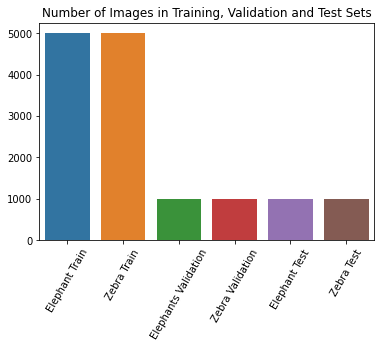

In [4]:
# barplot showing that the number of elephants vs zebras in each of the sets is equal, i.e. that the dataset is balances
counts_of_animals_in_training_data = [
    len(os.listdir('data/train/Elephant_train')),
    len(os.listdir('data/train/Zebra_train')),
    len(os.listdir('data/valid/Elephant_valid')),
    len(os.listdir('data/valid/Zebra_valid')),
    len(os.listdir('data/test/Elephant_test')),
    len(os.listdir('data/test/Zebra_test')),
    ]
labels_for_count_of_animals_in_training_data_plot = ['Elephant Train','Zebra Train','Elephants Validation','Zebra Validation','Elephant Test','Zebra Test']
sns.barplot(x = labels_for_count_of_animals_in_training_data_plot, y = counts_of_animals_in_training_data)
plt.title('Number of Images in Training, Validation and Test Sets')
locs, graphLabels = plt.xticks()
plt.setp(graphLabels,rotation = 60)
plt.show()


From the above plot it is clear that the dataset is balanced, i.e. that in each of the sets of data (training, validation, testing) the counts in each category are even. This is an indication that the accuracy metric will give valuable insight into how well the models perform and we will use it as the primary performance metric along with binary cross entropy loss. Thus none of precision, recall, or  f1 score will be considered.

## Data Augmentation
The training data consists of 10000 images. This is relatively low and we intend to increase it by 20%. Increasing the size of the training data set serves to combat overfitting as well as to contribute to model robustness. However, we have kept this value low as if there are too many similar pictures in the dataset, the model can again be prone to overfitting. Thus, to augment the training data, we will transform 2000 of the training samples using two distinct methods - they will be flipped as well as cropped (and zoomed in on) to ensure that they are sufficiently different from the original training data. For convenience these steps were completed when the images were read into the training data in the Data Analysis section. 

The transformed (flipped and cropped) images can be seen beside their original counterparts below.

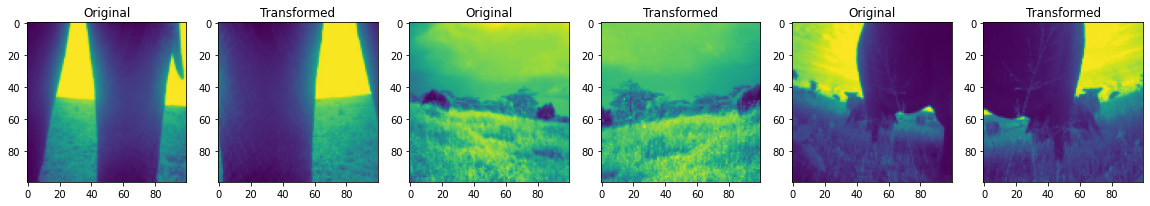

In [5]:
fig1, ax1 = plt.subplots(1,6, figsize = (20,20))
#Display original images next to cropped and zoomed versions
for i in range(8,14,2):
    ax1[i-8].imshow(train_data[indexes_of_augmented_images[i]-1][0])
    ax1[i-8].set_title('Original')
    ax1[i-8+1].imshow(train_data[indexes_of_augmented_images[i]][0])
    ax1[i-8+1].set_title('Transformed')
plt.show()

## Data Preparation
The original data was 330x330 pixels. Considering that we intend to define neural networks to classify these images, it would be beneficial to resize the images. This is because each pixel increases the dimension of the input and layers with more nodes will be required to extract insightful information from the images. This not only increases the complexity of the model, it also increases the time required for computation. Thus, the images were resized to 100x100 pixels; this was done when reading in the images for convenience.

Furthermore, the original images were in full colour. Given that the likely distinctions between the elephants and zebras will lie in the differing patterns (striped vs monochrome) and that the colors of zebra and elephants (black, white and gray) fall into the gray scale spectrum anyway, we can convert the images to gray scale. A great benefit to doing this is that each sample image will have its dimension reduced, specifically (R, G, B) → (value). This was done when reading in the images for convenience. This is also normalization as now the values for each pixel are just a value between 0 and 1 representing the brightness of that pixel.

In the dataset, the images are indexed so that the elephants are grouped separately from the zebras, however, for the models to be trained well, it will be of benefit to shuffle (randomize the order of) the input images so that the models do not fit to all of one category first and give weight to patterns which are irrelevant to the discrimination between the categories, elephant and zebra.

At this point, the images are stored in a list and the Neural Network models require the data in the form of arrays, so these will be converted to numpy arrays.

### Shuffle the Data Order

In [6]:
random.seed(2022)
random.shuffle(train_data)
random.shuffle(test_data)
random.shuffle(valid_data)

### Conversion to Arrays

In [7]:
X_train = []
y_train = []
for feature, label in train_data:
    X_train.append(feature)
    y_train.append(label)

X_valid = []
y_valid = []
for feature, label in valid_data:
    X_valid.append(feature)
    y_valid.append(label)

X_test = []
y_test = []
for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

X_train = np.array(X_train).reshape(len(X_train), 100, 100, 1)
y_train = np.array(y_train).reshape(len(y_train), 1)

X_valid = np.array(X_valid).reshape(len(X_valid), 100, 100, 1)
y_valid = np.array(y_valid).reshape(len(y_valid), 1)

X_test = np.array(X_test).reshape(len(X_test), 100, 100, 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

# Dimension Check
print(X_train.shape)

(11999, 100, 100, 1)


This dimension check was done to ensure that the correct number of images are in the training set and that they are the correct size. Since there 10000 images, one of which was corrupt, and we augmented the training data with a further 2000 transformed images, the number of images is correct. Also, the dimensions of each image is correct and we can proceed.

### Display Sample of Prepared Data

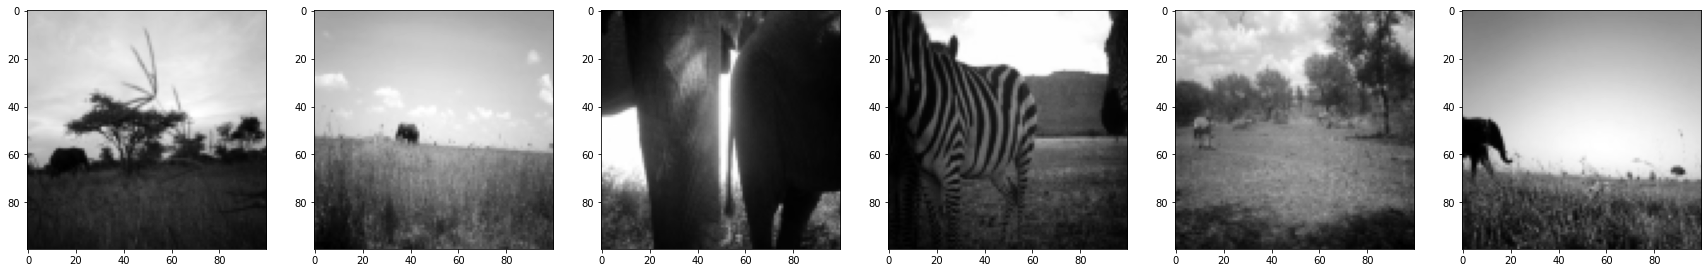

In [8]:
fig, ax = plt.subplots(1,num_plots, figsize = (30,30))

for i in range(num_plots):
    rand_image = np.random.randint(2000)
    ax[i].imshow(X_valid[rand_image],cmap=plt.cm.gray)
    
plt.show()

The images have been prepared through resizing to 100x100 and grayscaling as can be seen above.

## Model Choice
The use of a Convoluted Neural Network (CNN) is the industry standard for image classification. Therefore, rather than using different types of Neural Networks, we intend to use multiple CNNs with layers in different configurations. The layers we are considering are:

    > Dense Layer (Dense): fully connected layer constructed using a linear operation that maps every input to the output (i.e. each input is considered in determining the output). 
    
    > Convolutional Layer (Conv2D): creates a mapping of the original image that looks for patterns such as edges by grouping inputs; this type of layer has fewer parameters than a Dense layer with a matching number of nodes and thus adds less complexity to the model.
    
    > Pooling Layer (MaxPool2D): groups inputs in the same region and assigns one value to the group, thereby simplifying the input; this also serves to lessen the complexity of the model.
    
    > Flatten Layer (Flatten): converts the output of the Convolutional Layer to a form that is interpretable by the Dense Layer, thereby acting as a bridge between these two layers.
    
Multiple models of various configurations, varying complexities and differing hyperparameters will be considered. By adding and removing complexity as well as altering the hyperparameters, we aim to iteratively improve the accuracy of each subsequent model.

The process of adding layers in this way can be generalized and so a function will be written to create and compile the models.

From here on, configurations of these layers will be expressed by the first letters of the names of the layers in their appropriate order.

##### ***D: Dense, C: Convolutional, P: Pooling, F: Flatten. The configuration CFD, for example, begins with a Convolutional Layer, which is followed by a Flatten Layer and ends with a Dense Layer.***

### Function for Creating and Compiling the Models

In [9]:
set_seed(2022)
def createModel(number_of_layers, output_activation, opt='adam'):
    
    model = Sequential()
    for i in range(number_of_layers):
        model.add(Conv2D(32,(3,3),activation='relu',padding='same', input_shape = (100,100,1)))
        model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation=output_activation))
    model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    print('Model Summary:')
    print(model.summary())
    
    return model

#### Model 1
The first model that we are creating is a CNN with the configuration: CPFDD (as explained above). This model's complexity is moderate as there are about 5 million total parameters, as shown in the model summary below. The default - adam - optimizer and the softmax output activation will be used. The intention here is that this model will create a baseline for performance as well as complexity.

In [10]:
cnn1 = createModel(number_of_layers=1, output_activation='softmax')
history1 = cnn1.fit(X_train, y_train, epochs = 10,validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 64)                5120064   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_______________________________

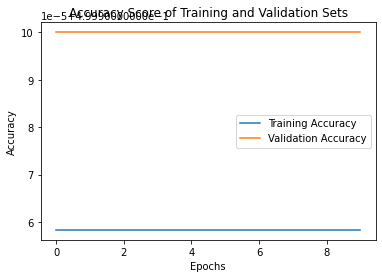

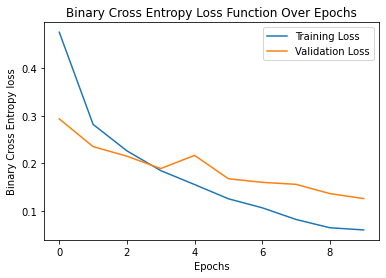

In [11]:
#function to create line plots of the accuracy over the epochs
def plot_acc_vs_epochs(hist):
    plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
    plt.title("Accuracy Score of Training and Validation Sets")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#function to create line plots of the loss over the epochs
def plot_loss_vs_epochs(history):
    plt.plot(history.history['loss'],label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.title("Binary Cross Entropy Loss Function Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy loss")
    plt.legend()
    plt.show()

                
        
plot_acc_vs_epochs(history1)
plot_loss_vs_epochs(history1)


In fitting this model, it can be seen that the softmax output activation caused the model to stagnate. This is because softmax is useful for classifcation problems where the number of categories exceeds two, that is, it is ill-suited to binary classfication. No further commentary will be made on the performance of this model as we do not believe this to be a valid model.

#### Model 2
For model 2, we will take heed of the results of the first model and change the output activation from softmax to sigmoid, which is suited to binary classification; all else will remain the same. Considering that each time we fit a model, the computation time is very large, we will continue to tune in this way, changing configurations and parameters as we go - a process of trial and improvement. The configuration here is again CPFDD. Again, the default adam optimizer will be used to determine the isolated effect of changing the output activation. Binary cross entropy is appropriate as there are two categories.

In [12]:
cnn2 = createModel(number_of_layers=1, output_activation='sigmoid')
history2 = cnn2.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 80000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                5120064   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,120,449
Trainable params: 5,120,449
Non-trainable params: 0
_____________________________

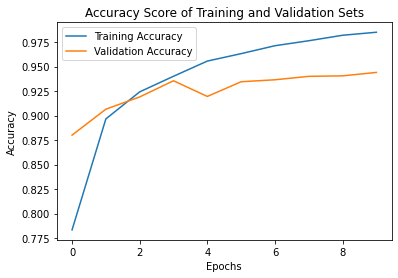

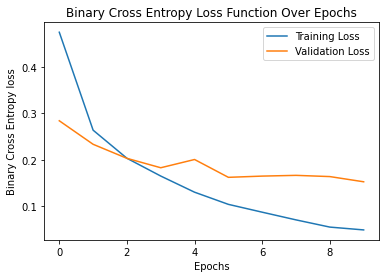

In [13]:
plot_acc_vs_epochs(history2)
plot_loss_vs_epochs(history2)

The results of this model are more promising than the first, highlighting that the sigmoid activation is better-suited to our problem. The accuracy of the model is above 90%. In the first graph, the general trend is that as the number of epochs increases, the accuracy increases, and in the second graph, the general trend is that the binary cross entropy loss decreases as the number of epochs increases. Therefore, we feel confident keeping the number of epochs high. Overfitting was low as there was little difference between the accuracy scores of the training and validation sets. The binary cross entropy was appropriate because this is a binary classification problem. We used the relu activation in the hidden layers of the model as this is the generally accepted activation function. We used the adam optimizer because it is adaptive.

#### Model 3
For this model, we aim to reduce the complexity of the model in the previous step. We will do this by adding more layers; this seems counter-intuitive, however, by adding another layer of both convolution and pooling to the start, we can decrease the total number of parameters in the model from over 5 million to about 1 million. The hyperparameters of the model will be kept the same. We hope to maintain the high level of accuracy attained in Model 2. The configuration will be of the form CPCPFDD.

In [14]:
cnn3 = createModel(number_of_layers=2, output_activation='sigmoid')
history3 = cnn3.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 64)

In [15]:
history3.history['val_accuracy']

[0.8700000047683716,
 0.8924999833106995,
 0.8995000123977661,
 0.9210000038146973,
 0.9309999942779541,
 0.9434999823570251,
 0.9259999990463257,
 0.9380000233650208,
 0.9520000219345093,
 0.9589999914169312]

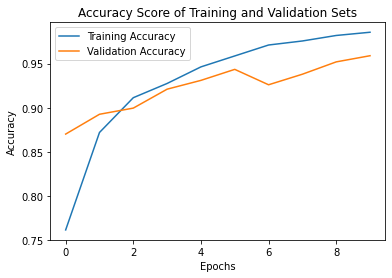

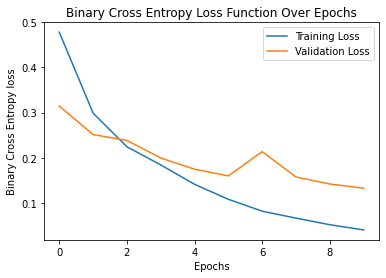

In [16]:
plot_acc_vs_epochs(history3)
plot_loss_vs_epochs(history3)


The accuracy results attained in Model 2 were replicated in Model 3, still exceeding 90%, while attaining a large reduction in complexity. The presence of overfitting was low as there was little difference between the accuracy scores of the training and validation sets. The hyperparameters that were previously justified were kept the same to determine the isolated effect of adding the additional hidden layers on model accuracy. In graph 1, the general trend is that as the number of epochs increases the accuracy increases, and in graph 2, the general trend is that as the number of epochs increases, the value of the binary cross entropy loss decreases.

#### Model 4
With this model, we intend to determine the effect of changing the optimizer from the adaptive adam optimizer to the more flexible SGD optimizer. The SGD optimizer requires the specification of a learning rate. We will perform a some basic hyperparameter tuning with the learning rate of the SGD model. The configuration of this model is CCFDD


We will first create the function to create a model to be hypertuned and also a RandomSearch object that will perform the hypertuning

In [32]:
# cnn4 = createModel(number_of_layers=1, output_activation='sigmoid', opt='SGD')
# history4 = cnn4.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), batch_size=64)

#

def build_model(hp):
    model=Sequential([
    Conv2D(
        32,(3,3),
        activation='relu',
        input_shape=(100,100,1)
    ),    
    Conv2D(
        32,(3,3),
        activation='relu'
    ),    
    Flatten(),
    Dense(
        64,
        activation='relu'
    ),    
    Dense(1,activation='sigmoid')
    ])     

    model.compile(optimizer=SGD(hp.Choice('learning_rate',values=[1e-2,1e-3])),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        
    return model
 

tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='output',
    project_name='classTune')
    

INFO:tensorflow:Reloading Oracle from existing project output\classTune\oracle.json


In [33]:
#Perform the hypertune search
tuner_search.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid), batch_size=64)

Trial 2 Complete [00h 05m 53s]
val_accuracy: 0.7540000081062317

Best val_accuracy So Far: 0.8174999952316284
Total elapsed time: 00h 11m 10s
INFO:tensorflow:Oracle triggered exit


In [47]:
#Obtain the best model and get a summary of it
cnn4=tuner_search.get_best_models(num_models=1)[0]
cnn4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 64)                18874432  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,884,065
Trainable params: 18,884,065
Non-trainable params: 0
_________________________________________________________________


Now that we have the best performing model we will now fit it to the training data so that it can be evaluated and compared to the other models

In [48]:
history4 =cnn4.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=64, initial_epoch=5)

Epoch 6/10
188/188 [==============================] - 89s 471ms/step - loss: 0.4317 - accuracy: 0.7958 - val_loss: 0.3900 - val_accuracy: 0.8185
Epoch 7/10
188/188 [==============================] - 116s 620ms/step - loss: 0.4068 - accuracy: 0.8127 - val_loss: 0.3695 - val_accuracy: 0.8410
Epoch 8/10
188/188 [==============================] - 133s 706ms/step - loss: 0.3916 - accuracy: 0.8198 - val_loss: 0.3505 - val_accuracy: 0.8420
Epoch 9/10
188/188 [==============================] - 115s 610ms/step - loss: 0.3683 - accuracy: 0.8341 - val_loss: 0.3719 - val_accuracy: 0.8400
Epoch 10/10
188/188 [==============================] - 113s 599ms/step - loss: 0.3514 - accuracy: 0.8412 - val_loss: 0.3309 - val_accuracy: 0.8465


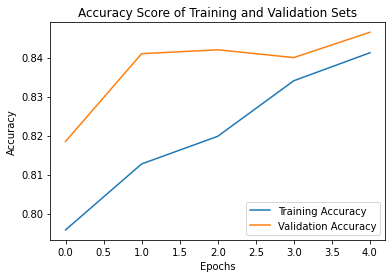

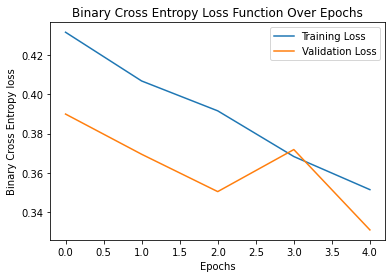

In [49]:
plot_acc_vs_epochs(history4)
plot_loss_vs_epochs(history4)

There was a clear reduction in accuracy from 95% in Model 2 to 85% in Model 4 even though model 4 went through hypertuning. We therefore conclude that adam is the better optimizer when compared to SGD as tuning the learning rate was not able to surpass it.

Given the accuracies and complexities of the models defined above, it has been determined that Model 3 is the model to continue with. This is because it has lower complexity than any of the other models and it has a validation accuracy of about 95%

## Model Assessment

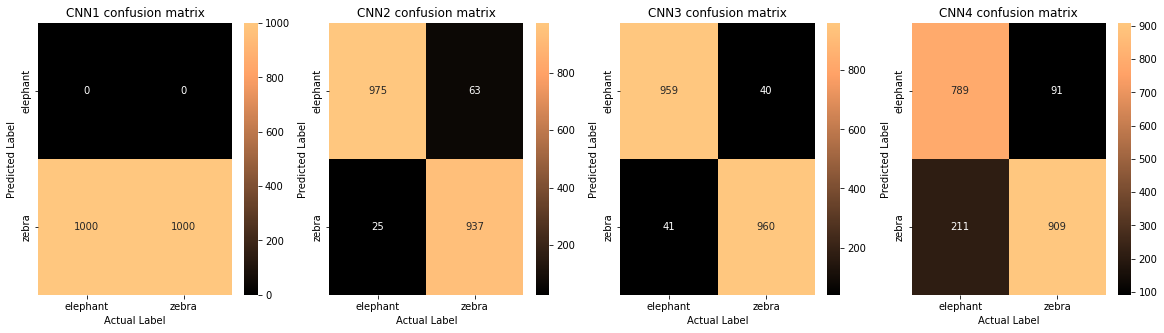

In [50]:
fig, ax = plt.subplots(1,4, figsize = (20,5))
def makeHeatmap(model,ax,title):
    
    y_pred = model.predict(X_test,verbose=0)

    for i in range(len(y_pred)):
        if y_pred[i] > 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    sns.heatmap(
        confusion_matrix(y_pred,y_test),
        annot = True,
        fmt = 'd',
        ax = ax,
        yticklabels=['elephant','zebra'],
        xticklabels=['elephant','zebra'],
        cmap=plt.cm.copper,
    )
    ax.set_title(title)
    ax.set_ylabel('Predicted Label')
    ax.set_xlabel('Actual Label')
    
    
models = [cnn1,cnn2,cnn3,cnn4]
titles = ['CNN1 confusion matrix','CNN2 confusion matrix', 'CNN3 confusion matrix','CNN4 confusion matrix']
for i in range(4):
    makeHeatmap(models[i],ax[i],titles[i])
plt.show()


The CNN1 confusion matrix clearly shows that using the softmax activation did not yield a valid model; the prediction in each case was a zebra. This is why the accuracy of the first model was 50% (due to balanced data).
The CNN2 and CNN3 confusion matrices were similar. This makes sense as the accuracies were the same in these models. For both of these models, the Type 1 (false positive) and Type 2 (false negative) amounts were low. This attests the ability of these models to accurately make category predictions.
The CNN4 confusion matrix shows high accuracy, but not as high as the Models 2 and 3 as there were significantly more errors.

In [51]:
print('Accuracies of each model')
model_names = ['CNN1','CNN2','CNN3','CNN4']

for i, model in enumerate(models):
    print('The accuracy of {} is {:.3}, and the number of parameters is {}'.format(model_names[i],model.evaluate(X_test,y_test,verbose=0)[1],count_params(model.trainable_weights)))
    


Accuracies of each model
The accuracy of CNN1 is 0.5, and the number of parameters is 5120449
The accuracy of CNN2 is 0.956, and the number of parameters is 5120449
The accuracy of CNN3 is 0.96, and the number of parameters is 1289697
The accuracy of CNN4 is 0.849, and the number of parameters is 18884065


### Commentry for model assessment here

The success the first model was equivalent to that of a model which randomly guesses the category labels of each input. Model 4 had a high accuracy and moderate complexity, as seen in its number of parameters. The accuracy front-runners were Models 2 and 3, and of these models, Model 3 was less complex having only about 1 million parameters as opposed to 5 million parameters. This indicates that having another Convolutional and Pooling layer before the Dense layers in the CNN (configuration CP-CPFDD rather than CPFDD) served to reduce complexity while maintaining accuracy.  

## Model Tuning
As has been explained, we informally tuned our model by changing the complexity (by altering the number of hidden layers) as well as changing the values of the optimizers or activation functions. We also performed hyperparameter tuning on the learning rate of model 4. It was not feasible to tune anything more than the learning rate due to time it took run and fit the models. A possible improvement to the models would be performing more intensive hyperparameter tuning if we had more time run and test the models.


 We can see from the plots associated with Model 3 that the accuracy scores and the loss function level off at 8 epochs. Thus, one further model will be defined - Model 5 - whereby the number of epochs used will be 8. The should reduce complexity while keeping accuracy relatively constant.


## The Final Model

This model will have the same specification as Model 3, save for its number of epochs it will run until (8 rather than 10). As with Model 3, the sigmoid output activation and adam optimizer will be used and it will have 2 sets of Convolutional Layers and Pooling Layers. Thus the configuration can be expressed as CPCPFDD using the convention defined previously.

In [43]:
finalModel = createModel(number_of_layers=2, output_activation='sigmoid')
finalModelHistory = finalModel.fit(X_train, y_train, epochs = 8,validation_data=(X_valid, y_valid), batch_size=64)

Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)

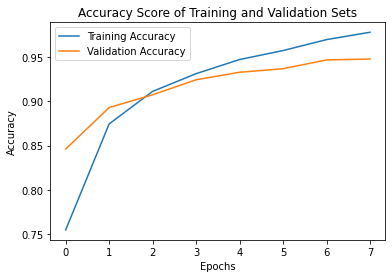

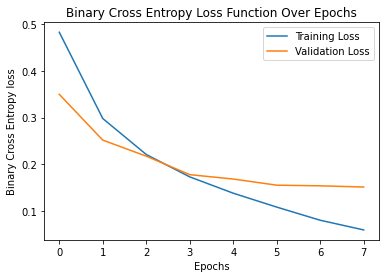

In [44]:
plot_acc_vs_epochs(finalModelHistory)
plot_loss_vs_epochs(finalModelHistory)

As can be seen in the plots of the final model, the accuracy scores of the training and validation sets were close. This is evidence that the model did not overfit to the training data.

The purpose of using 8 epochs rather than 10 was to remove the model progression wherein further epochs were run but there was no benefit in terms of gained accuracy and reduced loss, i.e. the 9th and 10th epochs where the curves flatten out. The served to decrease the computation time required for the fitting of the model and prevent overfitting on the training data.

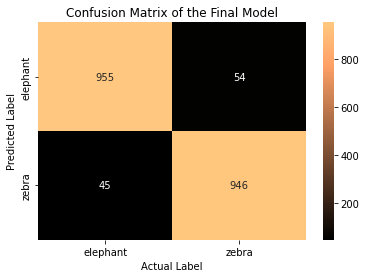

In [45]:
fig, ax = plt.subplots(1)

makeHeatmap(finalModel, ax, "Confusion Matrix of the Final Model")

In [46]:
print('The accuracy of the final model is {:.3}, and the number of parameters is {}'.format(finalModel.evaluate(X_test,y_test,verbose=0)[1],count_params(finalModel.trainable_weights)))

The accuracy of the final model is 0.951, and the number of parameters is 1289697


## Conclusion

Our final model had an accuracy of 95.1% on the testing data which is in line with model 3 but it takes fewer resources to fit as fewer epochs are required. Ultimately our final model maintains above 95% accuracy while being the most efficient of the 4 models run.

The performance of further models can be improved through a more extensive search into possible hyperparameter values. This will involve choosing alternative hyperparameters and possibly tuning them. Additionally, different configurations of the hidden layers could be explored. 

### Using the Final model to make predictions with some images visually

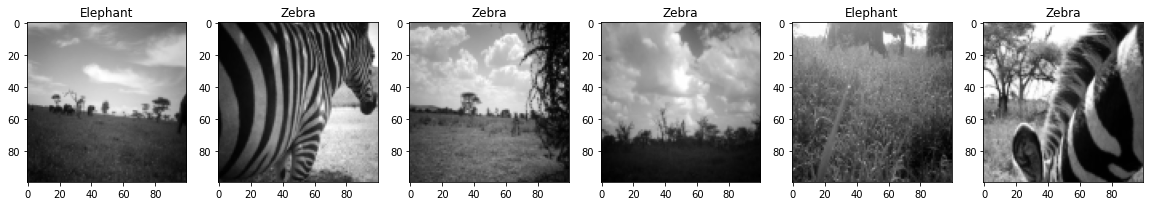

In [96]:
fig, ax = plt.subplots(1,6, figsize = (20,10))
np.floor(finalModel.predict(np.expand_dims(X_train[0], axis = 0), verbose=0)+0.5)
np.random.seed(2022)
for i in range(6):
    rand_image = np.random.randint(7000)
    pred = np.floor(finalModel.predict(np.expand_dims(X_train[rand_image], axis = 0), verbose=0)+0.5)
    ax[i].imshow(X_train[rand_image], cmap = plt.cm.gray)
    if pred == 1:
        ax[i].set_title("Zebra")
    else:
        ax[i].set_title("Elephant")

    